<a href="https://colab.research.google.com/github/Mariam-maghraby/Decision-tree-implementation-from-scratch/blob/master/Final_Transfer_learning_Mars_using_pretrainedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### https://colab.research.google.com/drive/1NziO_b-SW9KmWFh-6C8to9H_QAdpmCBZ?usp=sharing

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Install dependencies and 
!pip install albumentations==0.4.6
!pip install pycocotools --quiet

# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0
%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 30.0 MB/s 
     |████████████████████████████████| 948 kB 51.2 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=9529893715a55ee84312f413ed695d81eed9390d4989c7d2e0cb9a94c27eb9d5
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Cloning into 'vision'...
remote: Enumerating objects: 181679, done.
remote: Counting objects: 100% (1645/1645), done.
remote: Compressing o

In [4]:
# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

### Parameters

model_imp = "control"


In [5]:
!ls gdrive/MyDrive/Neuromatch_project

 Abstracts
 best_model.pth
 dataset
 Dataset_moon_and_mars.zip
'Final Transfer_learning_Mars.ipynb'
 Kaggle_Json
 model
 Moon_FastRCNN.ipynb
'Project Planning.gdoc'
'Project proposal.gdoc'
'Project Proposal: Transfer learning.gdoc'
 Tutorial_colab


In [6]:
### Import data

!unzip /content/gdrive/MyDrive/Neuromatch_project/Dataset_moon_and_mars.zip


Archive:  /content/gdrive/MyDrive/Neuromatch_project/Dataset_moon_and_mars.zip
   creating: mars/
   creating: mars/test_images/
 extracting: mars/test_images/neg0.JP2  
 extracting: mars/test_images/neg1.JP2  
 extracting: mars/test_images/neg10.JP2  
 extracting: mars/test_images/neg11.JP2  
 extracting: mars/test_images/neg12.JP2  
 extracting: mars/test_images/neg13.JP2  
 extracting: mars/test_images/neg14.JP2  
 extracting: mars/test_images/neg15.JP2  
 extracting: mars/test_images/neg16.JP2  
 extracting: mars/test_images/neg17.JP2  
 extracting: mars/test_images/neg18.JP2  
 extracting: mars/test_images/neg19.JP2  
 extracting: mars/test_images/neg2.JP2  
 extracting: mars/test_images/neg20.JP2  
 extracting: mars/test_images/neg21.JP2  
 extracting: mars/test_images/neg22.JP2  
 extracting: mars/test_images/neg23.JP2  
 extracting: mars/test_images/neg24.JP2  
 extracting: mars/test_images/neg25.JP2  
 extracting: mars/test_images/neg26.JP2  
 extracting: mars/test_images/neg2

In [7]:
from PIL import Image

#defining the files directory and testing directory
train_dir_Mars_img = "/content/mars/train_images"
test_dir_Mars_img =  "/content/mars/test_images"

train_dir_Mars_labels = "/content/mars/train_labels"
test_dir_Mars_labels = "/content/mars/test_labels"

# train_dir_Mars_img = "/content/drive/MyDrive/Neuromatch/dataset/mars/train_images"
# test_dir_Mars_img =  "/content/drive/MyDrive/Neuromatch/dataset/mars/test_images"

# train_dir_Mars_labels = "/content/drive/MyDrive/Neuromatch/dataset/mars/train_labels"
# test_dir_Mars_labels = "/content/drive/MyDrive/Neuromatch/dataset/mars/test_labels"

# we create a Dataset class which has a __getitem__ function and a __len__ function
class MarsImagesDataset(torch.utils.data.Dataset):

  def __init__(self, files_dir_img, labels_dir, width, height, phase, transforms=None):
    
    self.transforms = transforms
    self.files_dir_label = labels_dir
    self.files_dir_img = files_dir_img
    self.height = height
    self.width = width
    self.phase = phase
    
    # sorting the images for consistency
    # To get images, the extension of the filename is checked to be jpg
    
    self.imgs = [image for image in sorted(os.listdir(self.files_dir_img)) if ((image[:3] != "neg") & (image[:4]!="back"))]
  
    # classes: 0 index is reserved for background
    self.classes = [_, "Rockfall"]


  def __getitem__(self, idx):
    img_name = self.imgs[idx]

    image_path = os.path.join(self.files_dir_img, img_name)


    img = Image.open(image_path).convert('RGB')
    img_res = img.resize((self.width, self.height))
    img_res = np.array(img_res).astype(float)
    img_res /= 255.0
    
    # annotation file
    if self.phase == "train":
      annot_filename =  "train_labels_ma.csv"
    if self.phase == "test":
 
      annot_filename =  "test_labels_ma.csv"

    annot_file_path = os.path.join(self.files_dir_label, annot_filename)
    bounding_box = pd.read_csv(annot_file_path)

    boxes = []
    labels = []
    
    # cv2 image gives size as height x width
    wt, ht=img.size

    for ii in range(len(bounding_box)):
      if bounding_box.iloc[ii,0]==img_name:
        if 'neg' not in bounding_box.iloc[ii, 0]:
          labels.append(1)
          x_min=bounding_box.iloc[ii, 1]
          x_max=bounding_box.iloc[ii, 3]
          y_min=bounding_box.iloc[ii, 2]
          y_max=bounding_box.iloc[ii, 4]
      
          xmin_corr = int((x_min/wt)*self.width)
          xmax_corr = int((x_max/wt)*self.width)
          ymin_corr = int((y_min/ht)*self.height)
          ymax_corr = int((y_max/ht)*self.height)
          
          boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

    # convert boxes into a torch.Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)

    # getting the areas of the boxes
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) 

    # suppose all instances are not crowd
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["area"] = area
    target["iscrowd"] = iscrowd
    image_id = torch.tensor([idx])
    target["image_id"] = image_id

    if self.transforms:
      sample = self.transforms(image = img_res,
                                bboxes = target['boxes'],
                                labels = labels)
      img_res = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])
        
    return img_res, target

  def __len__(self):
    return len(self.imgs)

# check dataset
dataset_train = MarsImagesDataset(train_dir_Mars_img, train_dir_Mars_labels, 224, 224, "train")
print('Length of dataset:', len(dataset_train), '\n')

dataset_test = MarsImagesDataset(test_dir_Mars_img, test_dir_Mars_labels, 224, 224, "test")
print('Length of dataset:', len(dataset_test), '\n')

#getting the image and target for a test index.  Feel free to change the index.
img, target = dataset_train[75]


Length of dataset: 458 

Length of dataset: 26 



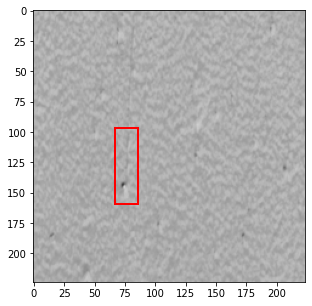

<Figure size 720x720 with 0 Axes>

In [8]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, a = plt.subplots(1,1)
  plt.figure(figsize = (10,10))
  fig.set_size_inches(5,5)
  a.imshow(img)
  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    a.add_patch(rect)
  plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset_test[7]
plot_img_bbox(img, target)

In [9]:
# Send train=True for training transforms and False for val/test transforms
def get_transform(train):
  if train:
    return A.Compose(
      [
        A.HorizontalFlip(0.5),
        # ToTensorV2 converts image to pytorch tensor without div by 255
        ToTensorV2(p=1.0) 
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )
  else:
    return A.Compose(
      [ToTensorV2(p=1.0)],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

In [10]:
# use our dataset and defined transformations
dataset_train = MarsImagesDataset(train_dir_Mars_img, train_dir_Mars_labels, 480, 480,"train", transforms=get_transform(train=True))
dataset_test = MarsImagesDataset(test_dir_Mars_img, test_dir_Mars_labels, 480, 480,"test", transforms=get_transform(train=False))

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
  dataset_train,
  batch_size=10,
  shuffle=True,
  num_workers=4,
  collate_fn=utils.collate_fn,
)

data_loader_test = torch.utils.data.DataLoader(
  dataset_test,
  batch_size=10,
  shuffle=False,
  num_workers=4,
  collate_fn=utils.collate_fn,
)


In [11]:
def get_object_detection_model(num_classes):
  # load a model pre-trained pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
  return model

In [12]:
if model_imp == "control":
  get_object_detection_model(2)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [13]:
if model_imp == "transfer":

  num_classes = 2
  device = torch.device("cuda")
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
  model.load_state_dict(torch.load("/content/gdrive/MyDrive/Neuromatch_project/best_model.pth"))
  for param in model.parameters():
    param.requires_grad = False   


  # load an instance segmentation model pre-trained pre-trained on COCO
  # get number of input features for the classifier
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  model.to(device)
  

In [14]:
import math, sys 

def train_epoch_ours(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

In [15]:
# train on gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2 # one class (class 0) is dedicated to the "background"

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=3,
  gamma=0.1
)

In [16]:
import math
import sys
import time
import torch

import torchvision.models.detection.mask_rcnn

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

@torch.no_grad()


def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for image, targets in metric_logger.log_every(data_loader, 100, header):
        image = list(img.to(device).float() for img in image)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(image)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

In [17]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=0.0
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        model, saving_path
    ):
        if current_valid_loss > self.best_valid_loss:
            print(f"\n AP improved from {self.best_valid_loss} to {current_valid_loss}")
            self.best_valid_loss = current_valid_loss
            
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save(
                #cuda,
                #'epoch': epoch+1,
                model.state_dict(),
                #'optimizer_state_dict': optimizer.state_dict(),
                #'loss': criterion,
                saving_path)

In [ ]:
# training for 5 epochs
num_epochs = 150

saving_path = f"/content/gdrive/MyDrive/Neuromatch_project/model/Mars_model_{model_imp}.pth"

metric_list = []

best_model = SaveBestModel()

for epoch in range(num_epochs):
    # training for one epoch

    train_epoch_ours(model, optimizer, data_loader_train, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    metrics_current_epoch = evaluate(model, data_loader_test, device=device)
    # save evaluation metrics (numpy array) to metric_list
    metric_list.append(metrics_current_epoch.coco_eval['bbox'].stats)

    average_recall = metrics_current_epoch.coco_eval['bbox'].stats[8]
    
    best_model(average_recall, model, saving_path=saving_path)
  
metric_array = np.array(metric_list) # convert list to np.array

In [ ]:
metric_array

In [ ]:
for p in model.parameters():
  print(p.requires_grad)

In [ ]:
# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.3):
  # torchvision returns the indices of the bboxes to keep
  keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
  
  final_prediction = orig_prediction
  final_prediction['boxes'] = final_prediction['boxes'][keep].cpu()
  final_prediction['scores'] = final_prediction['scores'][keep].cpu()
  final_prediction['labels'] = final_prediction['labels'][keep]
  
  return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
  return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:

# pick one image from the test set
img, target = dataset_test[20]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
  prediction = model([img.float().to(device)])[0]
  
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)
plt.figure(figsize=(10,10))
plot_img_bbox(torch_to_pil(img), nms_prediction)
plot_img_bbox(torch_to_pil(img), target)


In [ ]:
# @torch.no_grad()
# def evaluate_loss(model, data_loader, device):
#     val_loss = 0
#     model.train()
#     for images, targets in (data_loader):
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in targets.items()}]

#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())

#         # reduce losses over all GPUs for logging purposes
#         loss_dict_reduced = utils.reduce_dict(loss_dict)
#         losses_reduced = sum(loss for loss in loss_dict_reduced.values())
#         val_loss += losses_reduced

#     validation_loss = val_loss/ len(data_loader)
#     print(validation_loss)
#     return validation_loss

# val_loss=evaluate_loss(model, dataset_test, device)



In [ ]:
# F1 = precision*recall/(precision + recall)
